In [1]:
import numpy as np
import matplotlib.pyplot as plt
import mitsuba
mitsuba.set_variant('gpu_acoustic')
from enoki import *
cuda_set_log_level(0)

2021-06-16 21:40:18 INFO main [optix_api.cpp:56] Dynamic loading of the Optix library ..

In [2]:
def make_shoebox_scene(emitter_pos, sensor_pos, box_dimensions, radius, max_time, time_steps, 
                       spp, bins, rfilter, max_depth, samples_per_pass, scattering,absorption, hide_sensor=True):
    
    from mitsuba.core import ScalarTransform4f

    def transform(scale=None, rotate=None, translate=None):
        if translate is None:
            translate = [0, 0, 0]
        if scale is None:
            scale = [1, 1, 1]
        if rotate is None:
            rotate = ([0, 0, 0], 0)

        a = ScalarTransform4f.scale(scale)
        b = ScalarTransform4f.rotate(*rotate)
        c = ScalarTransform4f.translate(translate)
        return c * b * a

    global_translation = transform(translate=np.array(box_dimensions) / 2)

    scene = {
        "type": "scene",
        "bsdf_neutral": {
            "type": "acousticbsdf",
            "scattering": {
                "type": "spectrum",
                "value": scattering
            },
            "absorption": {
                "type": "spectrum",
                "value": absorption
            }
        },
        "emitter_shape": {
            "id": "emitter",
            "type": "sphere",
            "radius": radius,
            "to_world": transform(translate=emitter_pos),
            "emitter": {
                "type": "area",
                "radiance": {
                    "type": "uniform",
                    "value": 1
                }
            },
            "bsdf": {
                "type": "null"
            }
        },
        "sensor": {
            "type": "microphone",
            "to_world": transform(translate=sensor_pos),
            "sampler": {
                "type": "independent",
                "sample_count": spp
            },
            "myfilm": {
                "type": "tape",
                "time_steps": time_steps,
                "wav_bins": len(bins),
                "rfilter": rfilter
            }  
        },
        "shoebox": {
            "id": "shoebox",
            "type": "obj",
            "filename": "../resources/cuberoom.obj",
            "bsdf": {
                "type": "ref",
                "id": "bsdf_neutral"
            },
            "to_world": global_translation * transform(scale=np.array(box_dimensions) / 2)
        },
        "integrator": {
            "type": "acousticpath",
            "max_depth": int(max_depth),
            "max_time": max_time,
            "wavelength_bins": ','.join(str(x) for x in bins),
            "samples_per_pass": samples_per_pass
        }
    }
    return scene

def get_vals(data, size, copy=True):
    return np.array(data, copy=copy).reshape(size)

In [10]:
from mitsuba.core.xml import load_string, load_dict

config = {
    "bins": [1],#[1, 2, 3],
    "absorption": 0.5,# [(1, 0.1), (2, 0.5), (3, 0.9)],
    "scattering": 0.5,
    "max_time": 2,
    "time_steps": 200,
    "spp": 1,
    "samples_per_pass": 1,
    "box_dimensions": [25, 12, 7],
    "emitter_pos": [20, 7, 2],
    "sensor_pos": [9, 6, 1],
    "radius": .1,  
    "max_depth": 50,
    "rfilter": {
        "type": "box",
        "radius": 0.5
    }
}

scene_dict = make_shoebox_scene(**config)
scene = load_dict(scene_dict)

size = scene.sensors()[0].film().size()

sensor = scene.sensors()[0]
integrator = scene.integrator()

status = integrator.render(scene, sensor)
assert status

2021-06-16 21:40:26 DEBUG main [OBJMesh] Loading mesh from "cuberoom.obj" ..

2021-06-16 21:40:26 DEBUG main [OBJMesh] "cuberoom.obj": read 12 faces, 24 vertices (912 B in 0ms)

2021-06-16 21:40:26 INFO main [Scene] Building scene in OptiX ..

2021-06-16 21:40:27 INFO main [TimeDependentIntegrator] Rendering finished. (took 933ms)

<ipython-input-11-5f779731adb6>:8: RuntimeWarning: invalid value encountered in true_divide
  energy = vals / vals_count


Text(0.5, 1.0, 'Counts')

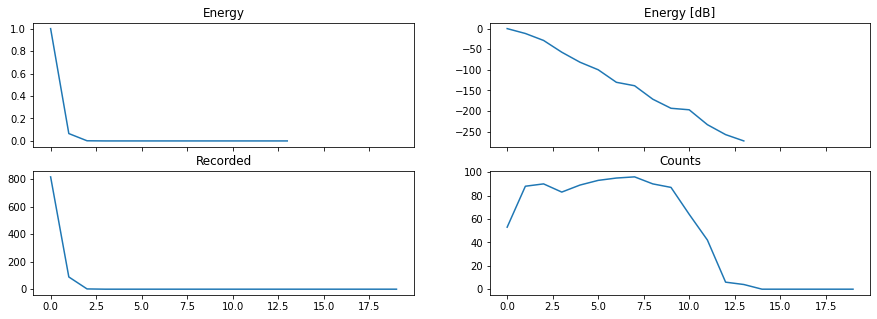

In [11]:
film = sensor.film()

hist = film.get_histogram()

vals = get_vals(hist.data(), film.size()).astype('float64')
vals_count = get_vals(hist.counts(), film.size()).astype('float64')

energy = vals / vals_count
energy /= energy[0]
energy_db = 10 * np.log10(energy)

fig, ((ax1, ax2), (ax3, ax4)) = plt.subplots(2, 2, sharex=True, figsize=(15, 5))
ax1.plot(energy)
ax1.set_title("Energy")
ax2.plot(energy_db)
ax2.set_title("Energy [dB]")
ax3.plot(vals)
ax3.set_title("Recorded")
ax4.plot(vals_count)
ax4.set_title("Counts")

In [12]:
#np.save('data/RT-EDC-box-5-5-5.npy', energy_db)
#np.save('data/RT-EDC-box-25-12-7.npy', energy_db)

In [6]:
print(np.finfo('float32'))
-60 / (10 * np.log10(0.8))

Machine parameters for float32
---------------------------------------------------------------
precision =   6   resolution = 1.0000000e-06
machep =    -23   eps =        1.1920929e-07
negep =     -24   epsneg =     5.9604645e-08
minexp =   -126   tiny =       1.1754944e-38
maxexp =    128   max =        3.4028235e+38
nexp =        8   min =        -max
---------------------------------------------------------------



61.91310695109703

In [7]:
print(np.max(vals))
print(np.min(vals))
np.spacing(np.min(vals))

2113.2412109375
0.0


5e-324

In [8]:
0.8**61

1.2259964326927152e-06

In [9]:
import pandas as pd
from utils import db_pd as db
df = pd.DataFrame()
for i,a in enumerate(config['absorption']):
    df.insert(0, f"a{a[1]:.1f}-s{config['scattering']:.1f}", vals[:,i])
df.insert(0, "time", np.linspace(0, config['max_time'], config['time_steps']))
df.set_index("time", inplace=True, drop=True)

(10 * np.log10(df.ewm(span = 1).mean())).plot()

TypeError: 'float' object is not iterable

In [ ]:
raven_hist = pd.read_pickle("raven/data.pkl")

In [ ]:
#db(raven_hist['a0.5-s0.5']).plot()
plt.plot(np.linspace(0, 4, 4000), energy_db[:,0], label='RT1')
plt.plot(np.linspace(0, 4, 4000), energy_db[:,1], label='RT5')
plt.plot(np.linspace(0, 4, 4000), energy_db[:,2], label='RT9')
plt.plot(np.linspace(0, 4.1, 411), db(raven_hist['a0.1-s0.5']), label='Raven1')
plt.plot(np.linspace(0, 4.1, 411), db(raven_hist['a0.5-s0.5']), label='Raven5')
plt.plot(np.linspace(0, 4.1, 411), db(raven_hist['a0.9-s0.5']), label='Raven9')
plt.legend()